In [163]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [145]:
p = [1.0, 1.0]
A = 100*math.pow(10, -18)
D = 2000

In [238]:
p = [
    791663.893676700321759525,
         0.014740362790060000
]
A = 39477*math.pow(10, -18)
D = 17400671.956579041226490126

In [261]:
p = [
    4.904115068653334558,
    2.910997640029410000,
    8.039665297200000000,
    9.900000000000000000
]
A = 45465*math.pow(10, -18)
D = 224742535.308930101394134153

In [262]:
nO = len(p)
nnO = math.pow(nO, nO)
aO = A * nnO * nnO
bO = nnO - aO

In [263]:
def computeK(a, b, n, prices):
    k = 10000
    for i in range(255):
        # print('-----')
        T, dTdk, dPdk, Tn, alpha = computeKparams(k, a, b, n, prices)

        # The derivative was divided by P.
        flk = (n+1)*dTdk*Tn/T + T*dPdk

        # The whole equation was divided by P, so alpha is alpha/P.
        fk = Tn - alpha
        
        newK = k - fk / flk
        
        if (abs(newK - k) < math.pow(10, -5)):
            return newK
        k = newK   
    raise RuntimeError("KDidntConverge()")

def computeBalancesForPrices(invariant, a, b, n, prices):
    k = computeK(a, b, n, prices)
    print('k', k)
    
    sumPriceDivision = 0
    for pi in prices:
        sumPriceDivision += a/(k*pi - a)
    
    balancesForPrices = np.zeros_like(prices)
    for i in np.arange(0, n):
        balancesForPrices[i] = (b*invariant/(k*p[i] - a))/(1-sumPriceDivision)

    return balancesForPrices

def computeKparams(k, a, b, n, prices):
    T = 1
    dTdk = 0
    dPdk = 0
    for pi in prices:
        den = (k*pi - a)
        T -= a/den
        dTdk += pi * a/(den*den)
        dPdk += pi/den

    alpha = b
    Tn = 1
    for j in range(n):
        Tn = Tn * T
        alpha = alpha * b / (k*prices[j] - a)
    return T, dTdk, dPdk, Tn, alpha

In [264]:
# Used only to plot the chart
def computeF_k(k, a, b, n, prices):
    T, Tl, Pl, Tn, alpha = computeKparams(k, a, b, n, prices)
    fk = Tn - alpha
    return fk

k_array = np.arange(0.06, 0.08, 0.0001)
f_k_array = np.zeros_like(k_array)
for i in np.arange(0, len(k_array)):
    ki = k_array[i]
    f_k_array[i] = computeF_k(ki, aO, bO, nO, p)

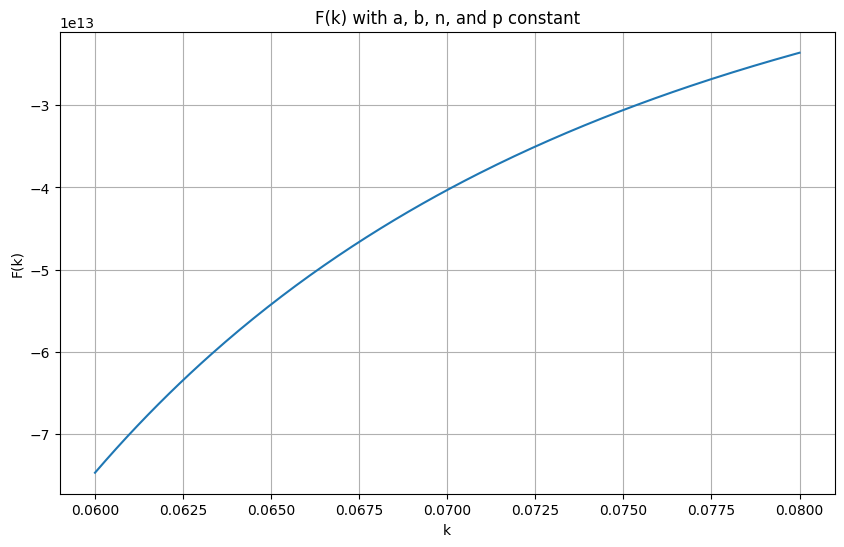

In [265]:
plt.figure(figsize=(10, 6))  # Set figure size for better visibility
plt.plot(k_array, f_k_array)
plt.xlabel('k')
plt.ylabel('F(k)')
plt.title('F(k) with a, b, n, and p constant')
plt.grid(True)  # Add grid for better readability
plt.show()

In [266]:
balancesForPrices = computeBalancesForPrices(D, aO, bO, nO, p)
print('balancesForPrices', balancesForPrices)

k 176.3725684797712
balancesForPrices [6.65171372e+07 1.12060446e+08 4.05747855e+07 3.29502722e+07]


In [267]:
def compute_invariant(A, balances):
    # Calculate the sum of balances
    total_balance = sum(balances)
    n = len(balances)
    prodBalances = 1
    for i in range(n):
        prodBalances = prodBalances * balances[i]

    # Initial invariant
    D = total_balance

    # Iteratively compute the invariant
    for i in range(500):
        fD = math.pow(D, n+1)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n)*D - D - A*math.pow(n, n)*total_balance
        flD = (n+1)*math.pow(D, n)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n) - 1
        newD = D - fD/flD

        # Check for convergence
        if abs(newD - D) < math.pow(10, -5):
            return newD
        D = newD

    raise RuntimeError("StableInvariantDidntConverge()")

In [268]:
def computeBalance(A, balances, D, tokenIndex):
    x = 1
    n = len(balances)
    nn = math.pow(n, n)
    prodBalances = 1
    sumBalances = 0
    for i in range(len(balances)):
        if (i != tokenIndex):
            prodBalances = prodBalances * balances[i]
            sumBalances += balances[i]
        
    for i in range(255):
        fx = A*nn*(sumBalances+x)*prodBalances*x + D*prodBalances*x - A*nn*D*prodBalances*x - math.pow(D, n+1)/(nn)
        flx = A*nn*(prodBalances*x + (sumBalances+x)*prodBalances) + D*prodBalances - A*nn*D*prodBalances
        newX = x - fx/flx
        if (abs(x - newX) < math.pow(10, -5)):
            return newX
        x = newX
    raise RuntimeError("StableInvariantDidntConverge()")

def computeOutGivenIn(A, balances, D, tokenInIndex, tokenOutIndex, amountIn):
    newBalances = balances.copy()
    newBalances[tokenInIndex] = newBalances[tokenInIndex] + amountIn
    newBalances[tokenOutIndex] = computeBalance(A, newBalances, D, tokenOutIndex)
    return balances[tokenOutIndex] - newBalances[tokenOutIndex]

In [282]:
print('balance for prices', balancesForPrices)
newD = compute_invariant(A, balancesForPrices)
print('old invariant', D)
print('new invariant', newD)
tvl = 0
for i in range(len(p)):
    tvl += p[i]*balancesForPrices[i]

print('TVL', tvl)

amountIn = balancesForPrices[0] * 0.000001;
pBase = p[0]
pFinal = np.zeros_like(p)
pFinal[0] = pBase
for i in range(len(p) - 1):
    amountOut = computeOutGivenIn(A, balancesForPrices, D, 0, i+1, amountIn)
    pFinal[i+1] = pBase * amountIn/amountOut

# These prices are not found by solidity!
print('final prices', pFinal)


balance for prices [6.65171372e+07 1.12060446e+08 4.05747855e+07 3.29502722e+07]
old invariant 224742535.3089301
new invariant 224742535.30966365
TVL 1304830780.3252118
final prices [4.90411507 2.91096255 8.03956837 9.89988065]


In [224]:
##### DECREASING INVARIANT AFTER SWAP
##### sol invariant before 201617446.48623902
##### sol invariant after  193922378.56664622
# solidityBeforeD = compute_invariant(A, [
#     45575439.844049416889099061,
#     99000000.000000000000550000,
#     53356285.364576242600000000,
#     26811482.293484759128000000
# ]);
# solidityAfterD = compute_invariant(A, [
#     30343306.944049416889099061,
#     99000000.000000000000550000,
#     68588739.617672685063661225,
#     26811482.293484759128000000
# ]);

##### INCREASING INVARIANT AFTER SWAP
##### sol invariant before 224742535.3097477
##### sol invariant after  240714566.51141584
# solidityBeforeD = compute_invariant(A, [
#      30343306.918375015467093024,
#     101258100.537713047032093112,
#     123039893.944666796219573682,
#      26361037.778195684017694686
# ]);
# solidityAfterD = compute_invariant(A, [
#      45575439.818375015467093024,
#     101258100.537713047032093112,
#     107806854.216760805352259390,
#      26361037.778195684017694686
# ]);

##### DECREASING INVARIANT AFTER SWAP
##### sol invariant before 2.0
##### sol invariant after  1.999899999721648
# solidityBeforeD = compute_invariant(A, [1.0,1.0]);
# solidityAfterD = compute_invariant(A, [
#      1.010000000000000000,
#      0.990000002199665215
# ]);

##### INCREASING INVARIANT AFTER SWAP
##### sol invariant before 1.999899999721648
##### sol invariant after  2.0
# solidityBeforeD = compute_invariant(A, [1.01,0.990000002199665215]);
# solidityAfterD = compute_invariant(A, [
#      1.000000000000000000,
#      1.000000000000000004
# ]);
amountOut = computeOutGivenIn(A, [1.0,1.0], 2.0, 0, 1, 0.01)
print(amountOut)

#print('sol invariant before', solidityBeforeD)
#print('sol invariant after ', solidityAfterD)

0.00990099009900991
